# PLL configuration

We'll be using the PLL auxiliaries to set up the PLL (EHXPLLL module on ECP5), as the parametrization can get somewhat complicated.
The previous blinky is enhanced such that two clocks from the PLL are fed to counters which, when certain value toggle the LEDs.

In [1]:
import config

In [2]:
import pprint
from pllaux import EHXPLLConfig

INT_FEEDBACK = False

PLL = EHXPLLConfig(100.0)

PLL.setClk(25.0) # Set primary clock in MHz
PLL.setClk(33.0, 1, 1) # Set secondary clock in MHz

PLL.params.internal_feedback = INT_FEEDBACK # Use feedback

PLL_CONFIG = PLL.configure()

print("Effective: %.2f MHz" % PLL.f_out)
print("VCO: %.2f MHz" % PLL.f_vco)
print()

# pprint.pprint(PLL_CONFIG)

Calculate PLL values for 25.00 MHz
mul: 1, div: 4
too low VCO 25.0
Effective: 25.00 MHz
VCO: 400.00 MHz



In [3]:
from myhdl import *
from synthesis.yosys.ecp5.components import EHXPLLL

@block
def pll(clki, reset, clkop, clkos, lock):
    intlock, lock0 = [ Signal(bool()) for i in range(2) ]
    clkop, clkos, clkos2, clkos3 = [ Signal(bool()) for i in range(4) ]
    refclk, clkintfb = [ Signal(bool()) for i in range(2) ]
    fb, intlock = [ Signal(bool()) for i in range(2) ]

    e = EHXPLLL(clki, fb, False, False, False, False, \
        False, False, \
        False, reset, \
        True, True, False, False, \
        clkop, clkos, clkos2, clkos3, lock0, intlock, \
        refclk, clkintfb, \
        **PLL_CONFIG)

    @always_comb
    def assign():
        if INT_FEEDBACK:
            fb.next = clkintfb
        else:
            fb.next = clkop

        lock.next = lock0
    
    return instances()

## Top level entity

Then we create the top level module. It's input/output ports are the true hardware ports as described in the preference file (LPF).

In [4]:
from myhdl import *

@block
def toplevel(clk_in, reset_n, uart_rxd, uart_txd, led, CLK_FREQ):
    "Top level entity with UART hard loopback"
    
    toggle_led_a, toggle_led_b = [ Signal(bool()) for i in range(2) ]
    counter_a, counter_b = [ Signal(intbv(0)[32:]) for i in range(2) ]
    
    clka, clkb, lock = [ Signal(bool()) for i in range(3) ]
    # We not using this reset signal
    reset = ResetSignal(0, 1, True)

    l = [ Signal(bool()) for i in range(8) ]
    l_out = Signal(intbv()[8:])

    # Instance the above PLL unit:
    inst_pll = pll(clk_in, reset, clka, clkb, lock)
    # FIXME: Variable args still flaky
#    inst_pll = PLL.generate(clk_in, lock, clka, clk1=clkb)
    
    @always_seq(clka.posedge, reset_n)
    def blink_a():
        counter_a.next = counter_a + 1
        if counter_a == CLK_FREQ:
            toggle_led_a.next = not toggle_led_a
            counter_a.next = 0

    @always_seq(clkb.posedge, reset_n)
    def blink_b():
        counter_b.next = counter_b + 1
        if counter_b == CLK_FREQ:
            toggle_led_b.next = not toggle_led_b
            counter_b.next = 0
            
    @always_comb
    def assign():
        l_out.next = concat(toggle_led_a, False, False, False, lock, False, toggle_led_b, False )
        
    @always_comb
    def assign_out():
        led.next = not l_out
        uart_txd.next =  uart_rxd
               
    
    return instances()

### Synthesis

In [5]:
from myhdl.conversion import yshelper

clk_in = Signal(bool())
uart_rxd, uart_txd = [ Signal(bool()) for i in range(2) ]
led = Signal(modbv()[8:])
reset_n = ResetSignal(1, 0, False)

blinky = toplevel(clk_in, reset_n, uart_rxd, uart_txd, led, 10000000)

design = yshelper.Design("blinky")
blinky.convert("yosys_module", design)

design.finalize("top")


VCO div: 1 mul: 4
Enable CLKOP with divider 15
Enable CLKOS with divider 11
VCO div: 1 mul: 4
Enable CLKOP with divider 15
Enable CLKOS with divider 11
Tolerating undefined bit width of divider_0_count for blackbox simulation
Tolerating undefined bit width of divider_1_count for blackbox simulation
Tolerating undefined bit width of VCO_0_edge for blackbox simulation
Tolerating undefined bit width of VCO_0_lastedge for blackbox simulation
CREATE Module: 'divider_0'
	Infer blackbox: 'divider_0'
Adding module with name: divider_1_1_c15_1
CREATE Module: 'divider_1'
	Infer blackbox: 'divider_1'
Adding module with name: divider_1_1_c11_1
CREATE Module: 'VCO_0'
	Infer blackbox: 'VCO_0'
Adding module with name: VCO_1_1_1_1_c1_c4
CREATE Module: 'EHXPLLL_0'
	Infer blackbox: 'EHXPLLL_0'
Adding module with name: EHXPLLL_1_1_c0_c0_c0_c0_c0_c0_c0_1_c1_c1_c0_c0_1_1_1_1_1_1_1_1
config param PLLRST_ENA = DISABLED
config param INTFB_WAKE = DISABLED
config param STDBY_ENABLE = DISABLED
config param DPHAS

#### RTL view

Verify wiring for PLL:

Generating RTL image...
Display...


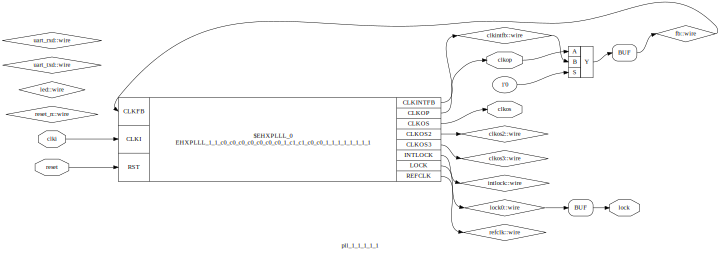

In [6]:
from ys_aux import to_svg
display(to_svg(design, "pll_1_1_1_1_1", 100))

## Simulation

The **functional** simulation of the `EHXPLLL` unit is emulated such that the phase trimming parameters are not respected.

In [7]:
CLK_HALF_PERIOD = int(500000.0 / 100.0)


@block
def testbench():
    clka, clkb, lock = [ Signal(bool()) for _ in range(3) ]

    clk_in = Signal(bool(0))
    reset = ResetSignal(1, 1, True)
    inst_pll = pll(clk_in, reset, clka, clkb, lock)

    @instance
    def sim():
        yield delay(20000)
        reset.next = False
        
        
    @always(delay(CLK_HALF_PERIOD))
    def clkgen():
        clk_in.next = not clk_in

    return instances()

tb = testbench()        
tb.config_sim(backend = 'myhdl', timescale="1ps", trace=True)
tb.run_sim(2000000)
tb.quit_sim()

VCO div: 1 mul: 4
Enable CLKOP with divider 15
Enable CLKOS with divider 11


<class 'myhdl._SuspendSimulation'>: Simulated 2000000 timesteps


Download trace: [testbench.vcd](testbench.vcd)

## Synthesize and map to ECP5

In [8]:
from ecp5aux import synthesize

synthesize(design)

json_filename = "plltest.json"

design.run("write_json %s" % json_filename)

### Running nextpnr


In [9]:
! nextpnr-ecp5 -q --json plltest.json --um5g-45k\
    --lpf boards/ecp5_versa.lpf --freq 100 --lpf-allow-unconstrained\
    --textcfg plltest.config --package=CABGA381

## Programming your target

In [10]:
! ecppack --svf plltest.svf plltest.config plltest.svf
! sudo openocd -f boards/ecp5_versa.cfg -f boards/LFE5UM5G-45F.cfg \
    -c "transport select jtag; init; svf plltest.svf quiet; exit"

Open On-Chip Debugger 0.10.0
Licensed under GNU GPL v2
For bug reports, read
	http://openocd.org/doc/doxygen/bugs.html
none separate
adapter speed: 5000 kHz
Info : auto-selecting first available session transport "jtag". To override use 'transport select <transport>'.
Warn : Transport "jtag" was already selected
Info : clock speed 5000 kHz
Info : JTAG tap: ecp5.tap tap/device found: 0x81112043 (mfg: 0x021 (Lattice Semi.), part: 0x1112, ver: 0x8)
Warn : gdb services need one or more targets defined
svf processing file: "plltest.svf"

Time used: 0m2s143ms 
svf file programmed successfully for 1068 commands with 0 errors
